# This notebook analyzes the Mac sample against galaxies with the same LRG cuts from Petrillo and SDSS.
(i) The low-z (z < 0.4) LRG colour-magnitude selection of
Eisenstein et al. (2001), adapted to including more sources
(fainter and bluer):
r < 20
|c perp | < 0.2
r < 14 + c par /0.3
where
(1)
c par = 0.7(g − r) + 1.2[(r − i) − 0.18)]
c perp = (r − i) − (g − r)/4.0 − 0.18

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
from matplotlib_venn import venn3, venn3_circles
import matplotlib.lines as lines
from astropy import constants as const
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
# import ephem
from astropy.cosmology import FlatLambdaCDM
from scipy import stats as sci

In [ ]:
### Samples 02/15/20
#spec = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/spec_candidates_021320.csv')
mac = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/mac_candidates_021320.csv')
#zoo_121519 = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/zoo_candidates_021320.csv.csv')

## Load in MagPhys to combine M* and z

In [ ]:
# Opening GAMA MagPhys data from G09, G12, and G15 (DR3)
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/MagPhys.fits')  # open a FITS file
hdul.verify('fix')
magphys_data = hdul[1].data  # assume the first extension is a table
print(magphys.info())

# take ID and templates/z from first and second fit
magphys_id = magphys_data.CATAID
magphys_mass = magphys_data.mass_stellar_best_fit
magphys_z = magphys_data.Z

#zip to list
magphys_list = list(zip(magphys_id, magphys_mass, magphys_z))

# create dataframe
magphys = pd.DataFrame(magphys_list, columns = ['GAMA_ID','STELLAR_MASS','Z'])
magphys

## Open LambdarCat data for fluxes

In [ ]:
# Opening GAMA LambdarCat data from G09, G12, and G15 (DR3)
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/LambdarCat.fits')  # open a FITS file
hdul.verify('fix')
photo_data = hdul[1].data  # assume the first extension is a table
#print(gama_data.columns)

# take ID and flux measurements in g, r, and i
photo_id = photo_data.CATAID
photo_g_flux = photo_data.g_flux
photo_r_flux = photo_data.r_flux
photo_i_flux = photo_data.i_flux

#zip to list
photo_list = list(zip(photo_id, photo_g_flux, photo_r_flux, photo_i_flux))

# create dataframe
photo = pd.DataFrame(photo_list, columns = ['GAMA_ID','g_flux','r_flux','i_flux'])
photo

In [ ]:
r = -2.5*np.log10(photo.r_flux)
r

Here is the Petrillo LRG cuts:

r < 20 
|c perp | < 0.2 
r < 14 + c par /0.3
where:
c par = 0.7(g − r) + 1.2[(r − i) − 0.18)] 
c perp = (r − i) − (g − r)/4.0 − 0.18

I would have to calculate the magnitude from the flux. I can get the magnitude from a different catalog.

## g-band magnitude (AB)

In [ ]:
# Opening GAMA LambdarCat data from G09, G12, and G15 (DR3)
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/LambdarSDSSg.fits')  # open a FITS file
hdul.verify('fix')
photo_g_data = hdul[1].data  # assume the first extension is a table
#print(photo_g_data.columns)

# take ID and mag in g
photo_g_id = photo_g_data.LAMID
# LAMID is GAMA ID where applicable.
photo_g_mag = photo_g_data.ABMagDFA

photo_g_list = list(zip(photo_g_id, photo_g_mag))

photo_g = pd.DataFrame(photo_g_list, columns = ['GAMA_ID', 'g'])
photo_g.info()

In [ ]:
# GAMA_ID is given in bytes, need to decode. #b'8000'.decode("utf-8")
#photo_g_id.decode("utf-8")
photo_g['GAMA_ID'] = photo_g['GAMA_ID'].str.decode("utf-8")

In [ ]:
# Remove IDs which have "New" in the name
photo_g = photo_g[~photo_g.GAMA_ID.str.contains('New')]
photo_g

In [ ]:
# Write IDs as integers
photo_g['GAMA_ID'] = photo_g.GAMA_ID.astype(int)

In [ ]:
photo_g

## r-band

In [ ]:
# Opening GAMA LambdarCat data from G09, G12, and G15 (DR3)
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/LambdarSDSSr.fits')  # open a FITS file
hdul.verify('fix')
photo_r_data = hdul[1].data  # assume the first extension is a table
#print(photo_g_data.columns)

# take ID and mag in g
photo_r_id = photo_r_data.LAMID
# LAMID is GAMA ID where applicable.
photo_r_mag = photo_r_data.ABMagDFA

photo_r_list = list(zip(photo_r_id, photo_r_mag))

photo_r = pd.DataFrame(photo_r_list, columns = ['GAMA_ID', 'r'])
photo_r.info()

In [ ]:
# GAMA_ID is given in bytes, need to decode. #b'8000'.decode("utf-8")
#photo_g_id.decode("utf-8")
photo_r['GAMA_ID'] = photo_r['GAMA_ID'].str.decode("utf-8")

In [ ]:
# Remove IDs which have "New" in the name
photo_r = photo_r[~photo_r.GAMA_ID.str.contains('New')]
photo_r

In [ ]:
# Write IDs as integers
photo_r['GAMA_ID'] = photo_r.GAMA_ID.astype(int)

In [ ]:
photo_r

## i-band

In [ ]:
# Opening GAMA LambdarCat data from G09, G12, and G15 (DR3)
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/LambdarSDSSi.fits')  # open a FITS file
hdul.verify('fix')
photo_i_data = hdul[1].data  # assume the first extension is a table
#print(photo_g_data.columns)

# take ID and mag in g
photo_i_id = photo_i_data.LAMID
# LAMID is GAMA ID where applicable.
photo_i_mag = photo_i_data.ABMagDFA

photo_i_list = list(zip(photo_i_id, photo_i_mag))

photo_i = pd.DataFrame(photo_i_list, columns = ['GAMA_ID', 'i'])
photo_i.info()

In [ ]:
# GAMA_ID is given in bytes, need to decode. #b'8000'.decode("utf-8")
#photo_g_id.decode("utf-8")
photo_i['GAMA_ID'] = photo_i['GAMA_ID'].str.decode("utf-8")

In [ ]:
# Remove IDs which have "New" in the name
photo_i = photo_i[~photo_i.GAMA_ID.str.contains('New')]
photo_i

In [ ]:
# Write IDs as integers
photo_i['GAMA_ID'] = photo_i.GAMA_ID.astype(int)
photo_i

## Now I create variables to establish criteria for satisfying Petrillo's LRG classification.

In [162]:
# create variables for the criteria
# convert to Johnson magnitude system (or # out addition for AB)
g = photo_g.g + 0.013
r = photo_r.r + 0.226
i = photo_i.i + 0.296

c_par = 0.7*(g - r) + 1.2*((r - i) - 0.18)
c_perp = (r - i) - (g - r)/4.0 - 0.18

# add columns c_par and c_perp to magphys
magphys['r'] = r
magphys['c_par'] = c_par
magphys['c_perp'] = c_perp

magphys

,GAMA_ID,STELLAR_MASS,Z,r,c_par,c_perp
0,6802,1.117000e+09,0.0505,20.037590,0.509509,-0.050600
1,6806,8.560000e+10,0.3312,19.888579,0.830829,-0.031077
2,6808,5.503000e+10,0.2294,18.072043,0.851541,0.035539
3,6810,1.204000e+11,0.3263,19.426987,0.712912,0.094676
4,6813,1.025000e+11,0.4846,19.433859,0.159310,0.061193
5,6816,2.230000e+09,0.0764,17.512449,0.334810,-0.041780
6,6820,8.074000e+10,0.4141,17.818030,0.346594,0.042821
7,6821,3.167000e+07,0.0038,20.009960,0.322340,-0.020465
8,6826,5.397000e+09,0.0728,17.734411,0.887324,0.032506
9,6830,3.006000e+09,0.1140,19.357847,0.334061,-0.019450


In [163]:
# Take Petrillo's criteria for LRG
gama_LRG = magphys[(magphys.r < 20) & (abs(magphys.c_perp)) & (magphys.r < 14 + magphys.c_par/0.3)]
gama_LRG = gama_LRG[abs(gama_LRG.r) < 100]
gama_LRG

,GAMA_ID,STELLAR_MASS,Z,r,c_par,c_perp
24,6859,7.283000e+09,0.0974,19.613873,1.707755,0.066539
27,6878,1.766000e+11,0.5460,17.677962,1.185576,-0.061827
54,6936,4.567000e+11,0.4412,19.852919,1.801997,-0.011445
68,6974,3.762000e+10,0.0738,16.270518,0.834446,0.005556
123,7104,1.768000e+10,0.0751,16.588074,0.788726,-0.003975
252,7454,5.482000e+10,0.1396,15.605548,0.526716,-0.007161
317,7622,8.846000e+10,0.1696,19.667694,1.914580,0.122676
424,7874,3.582000e+09,0.1054,14.809328,0.525827,0.019820
481,7997,4.258000e+10,0.1780,17.551006,1.179157,0.295894
515,8077,5.735000e+09,0.1000,19.460814,1.703645,0.221249


## Plot z to mass for both ML candidates and GAMA LRGs

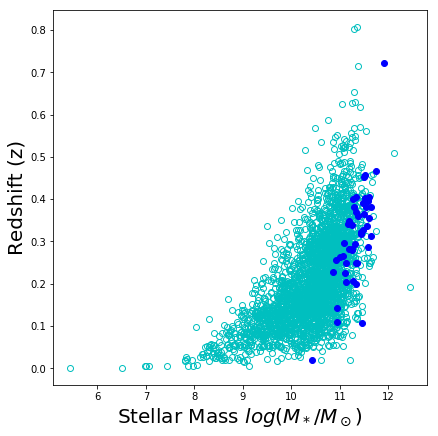

In [164]:
# Three-panel plot
from matplotlib.ticker import NullFormatter
nullfmt   = NullFormatter()         # no labels
# definitions for the axes
left, width = 0.1, 0.65
lower, height = 0.1, 0.65
lower_h = left_h = left+width+0.02
    
rect_scatter = [left, lower, width, height]
#rect_histx = [left, lower_h, width, 0.2]
#rect_histy = [left_h, lower, 0.2, height]
    
    # start with a rectangular Figure
plt.figure(1, figsize=(8,8))
    
axScatter = plt.axes(rect_scatter)
#axHistx = plt.axes(rect_histx)
#axHisty = plt.axes(rect_histy)

binwidth = 0.5
bins=20

    # no labels
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)

axScatter.plot(np.log10(gama_LRG.STELLAR_MASS), gama_LRG.Z, 'co', fillstyle = 'none')
axScatter.plot(np.log10(mac.STELLAR_MASS), mac.Z, 'bo')

axScatter.set_xlabel(r'Stellar Mass $log(M_*/M_\odot)$', fontsize=20)
axScatter.set_ylabel(r'Redshift (z)', fontsize=20)

#axHisty.hist(spec.Z, orientation='horizontal', range=[0,0.8], bins=bins,color='b', histtype = 'step', linewidth=3)
#axHisty.hist(pg_sample.Z, orientation='horizontal', range=[0,0.8], bins=bins,color='c', histtype = 'step', linewidth=3)

#axHistx.hist(np.log10(spec.STELLAR_MASS), range=[7,12], bins=bins,color='b', histtype = 'step', linewidth=3)
#axHistx.hist(np.log10(pg_sample.STELLAR_MASS), range=[7,12], bins=bins,color='c', histtype = 'step', linewidth=3)
plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/mac_gama_lrg_zmass.png')

# K-S Tests of z and M*

In [157]:
sci.ks_2samp(mac.Z, gama_LRG.Z)

Ks_2sampResult(statistic=0.4550206643196082, pvalue=4.4971669162499374e-09)

In [158]:
sci.ks_2samp(mac.STELLAR_MASS, gama_LRG.STELLAR_MASS)

Ks_2sampResult(statistic=0.7396066125822747, pvalue=2.8342015584728965e-23)

# A-D tests of z and M*

In [168]:
sci.anderson_ksamp([mac.Z,gama_LRG.Z])

/home/shawn/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: p-value floored: true value smaller than 0.001
  """Entry point for launching an IPython kernel.


Anderson_ksampResult(statistic=27.065349357007307, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

In [173]:
sci.anderson_ksamp([mac.STELLAR_MASS,gama_LRG.STELLAR_MASS])

/home/shawn/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: p-value floored: true value smaller than 0.001
  """Entry point for launching an IPython kernel.


Anderson_ksampResult(statistic=106.45890178238562, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)